# Dataset Checklist

In the previous [input preparation](0.Kitti_Dataset_Preparation.ipynb) session, we converted Kitti dataset from its original format to the JSON format as required by [Azure AutoML for Images platform](https://techcommunity.microsoft.com/t5/azure-ai/announcing-automated-ml-automl-for-images/ba-p/2843034). <br>

In this notebook, we will conduct explorative analysis on the train & validation dataset, to understand dataset characteristics like dataset size, image/ bounding box resolution, label imbalance situations etc. These will help greatly on the future [Metrics Analysis & Tunings](link pending) notebook.

We will utilize tools such as `InputAnalyzer`, `InputVisualizer` that were built along with this notebook, for the specific use of Azure AutoML for Images JSON labels.



In [1]:
from utils.data_utils import *

## Preparation Step: Get Labels

In [2]:
analyzer = InputAnalyzerOD()
analyzer.add_file("./workspaceblobstore/kitti_single/train.json", "train")
analyzer.add_file("./workspaceblobstore/kitti_single/val.json", "validation")
analyzer.aggregate_dfs()

Added train dataframe with shape (32422, 10)
Added validation dataframe with shape (8148, 10)
Aggregating 2 dataframes.


,fname,width,height,train_type,label
0,workspaceblobstore/kitti_single/training/image...,1224,370,validation,[Pedestrian]
1,workspaceblobstore/kitti_single/training/image...,1242,375,train,"[Truck, Cyclist, Car]"
2,workspaceblobstore/kitti_single/training/image...,1242,375,validation,"[Misc, Car]"
3,workspaceblobstore/kitti_single/training/image...,1242,375,validation,[Car]
4,workspaceblobstore/kitti_single/training/image...,1242,375,train,[Car]


Aggregating bbox level 2 dataframes.
bbox_df


,fname,width,height,topX,topY,bottomX,bottomY,label,isCrowd,train_type
0,workspaceblobstore/kitti_single/training/image...,1242,375,599.41,156.40,629.75,189.25,Truck,False,train
1,workspaceblobstore/kitti_single/training/image...,1242,375,387.63,181.54,423.81,203.12,Car,True,train
2,workspaceblobstore/kitti_single/training/image...,1242,375,676.60,163.95,688.98,193.93,Cyclist,False,train
3,workspaceblobstore/kitti_single/training/image...,1242,375,280.38,185.10,344.90,215.59,Car,False,train
4,workspaceblobstore/kitti_single/training/image...,1242,375,365.14,184.54,406.11,205.20,Car,True,train


## 1. Understand Number of Samples

We need to know the dataset size. If there’s only tens of images, we might want to increase the samples, or use simpler models to prevent overfitting. When the dataset gets larger, we should expect longer training hours, and we might want to use larger models to capture the variations within the dataset.

**Do we have sufficient samples?** 

* Dataset has about 6000 training samples and 1500 samples; 
* Images and bounding boxes both follows 80-20 train/ validation split.
* Dataset has at least 100 images per label , which should be sufficient for training. *A recommended number is at least have 15 samples for fewer-sample category.*

In [3]:
analyzer.image_count_analysis()
analyzer.bbox_count_analysis()

Total images:  7481
Analyzing images per train type:


,train_type,Percentage
train,5984,79.99%
validation,1497,20.01%


Total bounding boxes:  40570
Analyzing bboxes per train type:


,train_type,Percentage
train,32422,79.92%
validation,8148,20.08%


In [4]:
analyzer.label_analysis()

8 Labels:  Pedestrian, Truck, Cyclist, Car, Misc, Van, Tram, Person_sitting
Analyzing image count per label


,label,Percentage
Car,6684,89.35%
Van,2145,28.67%
Pedestrian,1779,23.78%
Cyclist,1141,15.25%
Truck,1036,13.85%
Misc,778,10.40%
Tram,349,4.67%
Person_sitting,99,1.32%


## 2. Understand Class Imabalance

For image classification, we will look at the number of images each label has; and for object detection, we care more about the number of bounding boxes each label has. 

**Do we have class imbalance issue?** 

Yes - 

*  `Car` is dominant classes with 6684 samples, while `Person_sitting` has only 99 samples and `Tram` has 349 samples. 
* From a bounding box perspective, `Car` class take up >70% of bounding boxes.

**In order to compensate the class imbalance issue, we can:**

1. Utilize external data source such as  [COCO](https://cocodataset.org/#home) or [OpenImages](https://storage.googleapis.com/openimages/web/index.html).

2. Use data-augmentation to create more variant for classes with fewer samples, thus increasing the number of samples for particular classes too.

3. Choose particular models/ hyperparameters for class imbalance. For example, `RetinaNet-ResNet50-FPN` has employed Focal Loss for class imbalance problems.

In [5]:
analyzer.label_analysis()
analyzer.bbox_label_analysis()

8 Labels:  Pedestrian, Truck, Cyclist, Car, Misc, Van, Tram, Person_sitting
Analyzing image count per label


,label,Percentage
Car,6684,89.35%
Van,2145,28.67%
Pedestrian,1779,23.78%
Cyclist,1141,15.25%
Truck,1036,13.85%
Misc,778,10.40%
Tram,349,4.67%
Person_sitting,99,1.32%


Analyzing bbox count per label


,label,Percentage
Car,28742,70.85%
Pedestrian,4487,11.06%
Van,2914,7.18%
Cyclist,1627,4.01%
Truck,1094,2.70%
Misc,973,2.40%
Tram,511,1.26%
Person_sitting,222,0.55%


## 3. Understand Resolutions


**Do we have sufficiently large image input?**

* In Kitti dataset, the images are about 375 * 1242, and we easily identify the objects when we look at the image. 
* The aspect ratio is almost 1:4. If this image is to be fed into one of Azure object detection model, YoloV5 with default input size of 640*640 (TODO: link), the transformation will be: first, image is resized to 160 * 640, second, it is padded to 256 * 640. In this case, image becomes 1/3 of its original, it might be hard to visually identify some bounding box details. 
* We will need to adjust input size in hyperparameter tuning or enable the logic for small object detection. 


Analyzing images dimension across train_type:


,height,width
min,370.0,1224.0
max,376.0,1242.0
median,375.0,1242.0


Analyzing images dimension with train_type breakdown:


height             width             
              min  max median   min   max median
train_type                                      
train         370  376    375  1224  1242   1242
validation    370  376    375  1224  1242   1242

Creating image dimension plot


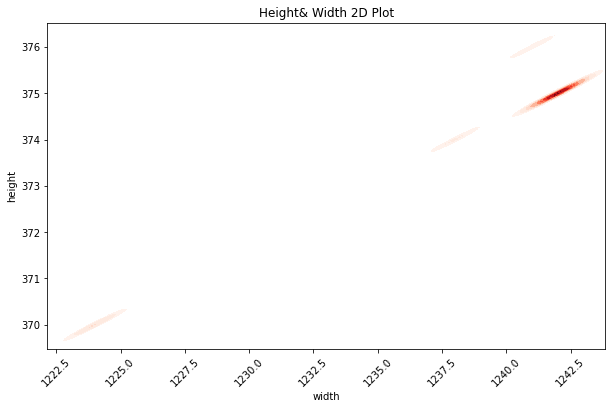

In [6]:
analyzer.image_dimension_analysis()
analyzer.image_dimension_plot()

**Do we have sufficiently large bounding box input?**

For object detection tasks, the size of the images isn’t the only thing to look at, we will also need to look at the bounding box sizes. 

* The bounding boxes has a distribution of 1:2:1 in large/ medium/ small size categories as in COCO evaluation. If the image input remains the same dimension after preprocessing, this is sufficient to build a model. (?need supporting for this statement)
* From per label perspective and bounding box dimension plots, we can see that:
    * `Car` has most large and medium samples.
    * `Tram`, `Person_sitting`, the two classes with fewer examples, has relative more portions of large and medium samples.
    * Almost every label has examples of very small (approximately 0) bounding boxes. This might be hard examples. **We might need to do data cleanup on these small samples**, depending on data visualization analysis in the last section.

In [7]:
analyzer.bbox_per_image_analysis()
analyzer.bbox_size_analysis()

Analyzing bounding boxes per images


min        1.0
max       22.0
median     5.0
Name: fname, dtype: float64

Analyzing bounding boxes per images per train type:


bbox_per_image           
                      min max median
train_type                          
train                   1  22      5
validation              1  21      5

Analyzing size per train type


bbox_size,large (>96x96),medium,small (<32x32)
train_type,,,
train,9316,17516,5590
validation,2379,4384,1385


Analyzing size per label


bbox_size,large (>96x96),medium,small (<32x32)
label,,,
Car,29.82%,53.75%,16.43%
Cyclist,18.44%,54.09%,27.47%
Misc,24.77%,56.83%,18.40%
Pedestrian,24.07%,53.96%,21.97%
Person_sitting,39.64%,57.66%,2.70%
Tram,47.36%,49.51%,3.13%
Truck,26.14%,58.96%,14.90%
Van,30.40%,53.91%,15.68%
All,28.83%,53.98%,17.19%


In [9]:
print("Analyzing size per label")
analyzer.bbox_size_analysis()

Analyzing size per label
Analyzing size per train type


bbox_size,large (>96x96),medium,small (<32x32)
train_type,,,
train,9316,17516,5590
validation,2379,4384,1385


Analyzing size per label


bbox_size,large (>96x96),medium,small (<32x32)
label,,,
Car,29.82%,53.75%,16.43%
Cyclist,18.44%,54.09%,27.47%
Misc,24.77%,56.83%,18.40%
Pedestrian,24.07%,53.96%,21.97%
Person_sitting,39.64%,57.66%,2.70%
Tram,47.36%,49.51%,3.13%
Truck,26.14%,58.96%,14.90%
Van,30.40%,53.91%,15.68%
All,28.83%,53.98%,17.19%


Creating bounding box dimension plot


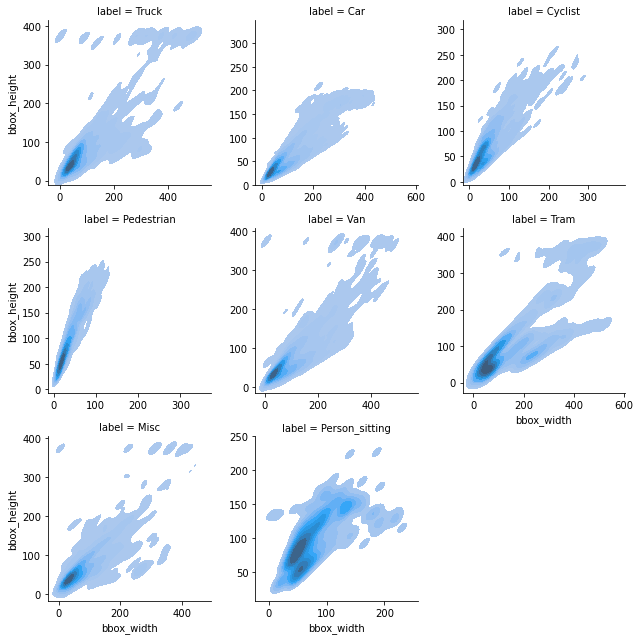

In [8]:
analyzer.bbox_dimension_plot()

## Conclusion


* The Kitti dataset has an image resolution of 375*1242, with small ~20% bounding boxes. Yolov5 may exhibit improved performance when the image size is set at higher resolutions to match the dataset resolutions. 

* The Kitti dataset has a class imbalance problem. The class imbalance problem can be addressed through Focal Loss in RetinaNet, which is part of the Azure AutoML for Images model offerings. 
